# 물류 운송에 관한 최적화 모델을 작성하고 목적함수를 최적화 해보자!

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [2]:
df_tc = pd.read_csv('trans_cost.csv', index_col = '공장')
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [3]:
df_tc.head()

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [4]:
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [5]:
df_supply

,W1,W2,W3
0,35,41,42


In [11]:
# 초기 설정
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

# 수리 모델 작성
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr} # LpVariable : 변수의 범위, 이름, 유형을 정한다.

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):  # 제약 조건 주기 -> 공장이 제조할 제품 수요량을 만족시키고 창고가 제공할 부품이 제공 한계를 넘지않게 해준다.
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i] # lpSum : 배열로 받아 모든 원소의 합을 만들어준다. -> 목적 함수를 만드는 법
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve() # solve 함수를 실행하면 v1 함수가 최적화가 된다.

# 총 운송 비용 계산
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)

print(df_tr_sol)
print("총 운송 비용:"+str(total_cost))

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용:1296.0


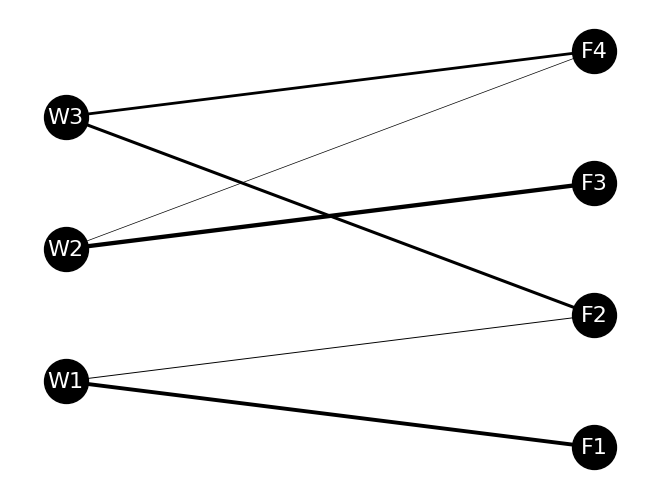

In [12]:
# 최적 운송 경로를 네트워크로 확인해보자
import matplotlib.pyplot as plt
import networkx as nx

# 데이터 불러오기
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 엣지 설정 & 엣지의 가중치 리스트화
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 엣지 추가
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # 엣지 가중치 추가
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)


# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])

# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 표시
plt.show()

# 가시화를 통해 창고 W1에서 공장 F1으로, 창고 W2에서 공장 F3으로, 창고 W3에서 공장 F2와 F4로의 공급이 대부분임을 알 수 있었다.
# 이에 운송 경로는 어느 정도 집중되어야 한다!라는 것을 알 수 있었다.

In [13]:
# 최적의 운송 경로가 제약 조건을 만족하는지 확인해보자.
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

# 공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요 조건 계산 결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급 조건 계산 결과:"+str(condition_supply(df_tr_sol,df_supply)))

# 모든 제약 조건을 만족하는 것을 확인할 수 있었다.

수요 조건 계산 결과:[1. 1. 1. 1.]
공급 조건 계산 결과:[1. 1. 1.]


In [ ]:
# 지금까지 운송 비용 최적화를 진행해 보았다. 물류 네트워크에서는 운송 뿐만 아니라 생산 계획도 중요한 요소이다.

In [14]:
df_material = pd.read_csv('product_plan_material.csv', index_col="제품")
print(df_material)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="제품")
print(df_profit)
df_stock = pd.read_csv('product_plan_stock.csv', index_col="항목")
print(df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan)

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


In [16]:
# 이익을 계산하는 함수를 만들어보자
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
    return profit

print("총 이익:"+str(product_plan(df_profit,df_plan)))

총 이익:80.0


In [18]:
# 생산 최적화 문제를 풀어보자

from ortoolpy import model_max

df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:,i]
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익:"+str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익:95.0


In [19]:
# 제약 조건을 확인하자

def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+"  사용량:"+str(temp_sum)+", 재고:"+str(float(df_stock.iloc[0][i])))
    return flag

print("제약 조건 계산 결과:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

원료1  사용량:25.0, 재고:40.0
원료2  사용량:80.0, 재고:80.0
원료3  사용량:50.0, 재고:50.0
제약 조건 계산 결과:[1. 1. 1.]


In [20]:
# 물류 네트워크 설계 문제를 해결해보자
제품 = list('AB')
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

# 운송비 #
tbdi = pd.DataFrame(((j,k) for j in 대리점 for k in 공장), columns=['대리점','공장'])
tbdi['운송비'] = [1,2,3,1]
print(tbdi)

# 수요 #
tbde = pd.DataFrame(((j,i) for j in 대리점 for i in 제품), columns=['대리점','제품'])
tbde['수요'] = [10,10,20,20]
print(tbde)

# 생산 #
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (공장,레인) for l in range(nl) for i in 제품),
                    columns=['공장','레인','제품','하한','상한'])
tbfa['생산비'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'상한']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa,dep = "대리점", dem = "수요",fac = "공장",
                                prd = "제품",tcs = "운송비",pcs = "생산비",lwb = "하한",upb = "상한")

print(tbfa)
print(tbdi2)

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0
  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000009  20.0
3  X   1  B   0   inf  1.0  v000010  10.0
4  Y   0  A   0  10.0  3.0  v000011  10.0
6  Y   1  A   0   inf  5.0  v000012   0.0
7  Y   1  B   0   inf  3.0  v000013  20.0
  대리점 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


/usr/local/lib/python3.10/dist-packages/ortoolpy/etc.py:1213: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  tbsm = pd.concat([tbdi2.groupby(facprd).VarX.sum(), tbfa.groupby(facprd).VarY.sum()], 1)


In [21]:
# 최적 네트워크의 운송 비용과 그 내역을 계산하자
tbdi2 = tbdi2[["공장","대리점","운송비","제품","VarX","ValX"]]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000001,10.0
1,X,P,1,B,v000002,10.0
2,X,Q,3,A,v000003,10.0
3,X,Q,3,B,v000004,0.0
4,Y,P,2,A,v000005,0.0
5,Y,P,2,B,v000006,0.0
6,Y,Q,1,A,v000007,10.0
7,Y,Q,1,B,v000008,20.0


In [22]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["운송비"].iloc[i]*tbdi2["ValX"].iloc[i]
print("총 운송비:"+str(trans_cost))

총 운송비:80.0


In [23]:
# 최적 네트워크의 생산 비용과 그 내역을 계산하자
print(tbfa)
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["운송비"].iloc[i]*tbdi2["ValX"].iloc[i]
print("총 운송비:"+str(trans_cost))

  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000009  20.0
3  X   1  B   0   inf  1.0  v000010  10.0
4  Y   0  A   0  10.0  3.0  v000011  10.0
6  Y   1  A   0   inf  5.0  v000012   0.0
7  Y   1  B   0   inf  3.0  v000013  20.0
총 운송비:80.0
